# MS027 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS027'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 114 x 1150016 (2246.1 s), ~1000.4 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1150016 (2246.1 s), ~8.8 MB, data loaded>

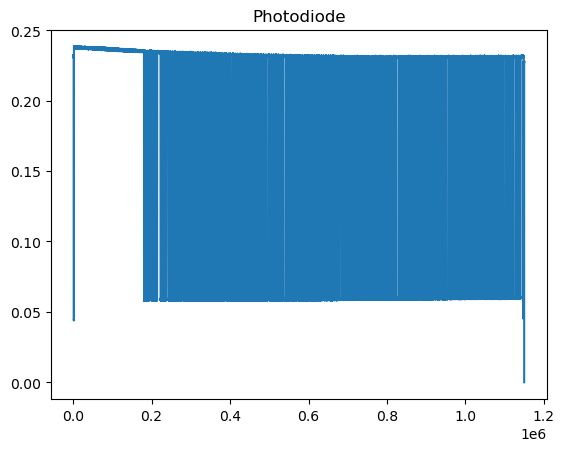

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Note
0,LaCaS1,A32sg_L,-1.996863,29.154473,-12.396027,-1.489100,25.800180,-10.918105,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Olfactory cortex,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS2,A32sg_L,-2.396240,31.151354,-7.997437,-2.305976,28.213844,-6.269909,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus C,NaN,NaN
2,LaCaS3,A32sg_L,-3.194992,33.148236,-3.198975,-3.581341,30.463378,-1.114084,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Unknown,WM,NaN
3,LaCaS4,A24rv_L,-3.594368,35.145118,1.199615,-4.402200,32.551975,3.559879,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Unknown,WM,NaN
4,LaCaS5,A24rv_L,-4.393121,37.141999,5.598206,-5.612624,34.849006,8.272237,White,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus F,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RHplT8,A21c_R,50.321429,-29.953224,-17.194489,58.208197,-32.244283,-9.492322,Gray,Right Cerebral White Matter,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
144,RHplT9,A21c_R,54.315191,-32.748859,-15.994873,62.645023,-35.095643,-8.145739,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus D,NaN,NaN
145,RHplT10,A21c_R,58.308954,-35.145117,-15.195129,67.068103,-37.522830,-7.125109,Gray,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right inferior middle temporal gyrus E,OOB,NaN
146,RHplT11,A21c_R,62.702093,-37.940751,-13.995514,71.887967,-40.228714,-5.508332,Unknown,Right MTG middle temporal gyrus,Unknown,R Middle Temporal Gyrus,R MTG,Right superior middle temporal gyrus E,OOB,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,14.0,mix,430.764912,430.773696,433.870105,435.885927,3.096409,0.0,-0.50,...,-0.207832,0.652502,0.347498,0.207832,0.000000,0.320424,0.000000,0.000000,0.528256,0.320424
1,2,108.0,loss,440.435121,440.435893,443.315561,443.322754,2.879668,-0.2,-0.72,...,-0.262647,0.455601,0.544399,0.000000,-0.230827,-0.230827,-0.230827,-0.230827,0.000000,0.000000
2,3,138.0,loss,450.364908,450.365628,453.943284,453.950405,3.577657,-0.5,-1.80,...,-0.472965,0.420516,0.579484,0.000000,-0.415664,-0.415664,-0.415664,-0.415664,0.000000,0.000000
3,4,84.0,gain,470.083897,470.084694,472.950046,474.966335,2.865352,0.5,0.00,...,0.000000,0.355648,0.644352,0.000000,0.000000,-0.106203,0.000000,0.000000,0.534644,-0.106203
4,5,77.0,gain,480.241354,480.242106,483.960198,483.968428,3.718091,0.4,0.00,...,0.000000,0.534425,0.465575,0.000000,-0.024646,-0.024646,-0.024646,-0.024646,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,133.0,loss,2163.995097,2163.996122,2169.035162,2171.052038,5.039039,-0.5,-1.00,...,-0.324308,0.625092,0.374908,0.324308,0.000000,0.415664,0.000000,0.000000,0.324308,0.415664
146,147,62.0,gain,2175.585131,2175.592078,2179.562990,2179.570656,3.970912,0.3,0.00,...,0.000000,0.336861,0.663139,0.000000,0.461678,0.461678,0.000000,0.000000,0.461678,0.461678
147,148,47.0,mix,2190.124242,2190.132279,2195.788264,2197.804533,5.655985,0.0,-1.10,...,-0.344770,0.937743,0.062257,-0.829445,-1.174215,-0.344770,-1.174215,-0.344770,0.000000,0.000000
148,149,115.0,loss,2203.081590,2203.082328,2208.131137,2208.138938,5.048809,-0.3,-0.74,...,-0.267308,0.544848,0.455152,0.000000,-0.032144,-0.032144,0.000000,0.000000,-0.032144,-0.032144


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [13]:
test_photo = photodiode_data

In [14]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [15]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            test_photo, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 160 pulses


## Make epochs

In [16]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [17]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [18]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [19]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 14704 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 17100 out of 17100 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 16970 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 17100 out of 17100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [20]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~100.4 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~167.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [21]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [22]:
epochs_all_evs[event].metadata

,rmolf2,rmolf11,rmolf12,lacas11,racas12,lmcms4,lmcms9,lmcms10,rmcms5,rmcms9,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.500,0.00,0.50,0.00,0.00,1.00,0.50,0.112592,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.20,-0.20,-0.20,-0.20,0.00,0.00,-0.262647,-0.230827
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.50,-0.50,-0.50,-0.50,0.00,0.00,-0.472965,-0.415664
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.555,0.555,0.00,0.61,0.00,0.00,1.11,0.61,0.534644,0.640847
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.86,-0.86,-0.86,-0.86,0.00,0.00,0.579966,0.555320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.500,0.500,0.00,0.50,0.00,0.00,1.00,0.50,-0.324308,-0.415664
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.25,-0.25,0.00,0.00,0.30,0.30,0.340641,0.461678
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.550,-1.650,-3.30,-1.10,-3.30,-1.10,0.00,0.00,0.484674,0.000000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,0.00,0.00,0.44,0.44,-0.267308,-0.299452


### Save epoched data

In [23]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)